<a href="https://colab.research.google.com/github/GGupta03/Personalized-Product-Recommendation-System/blob/main/Personalized_Product_Recommendation_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Read your dataset (replace 'marketing_sample_for_walmart_com-walmart_com_product_review__20200701_20201231__5k_data.tsv' with your dataset path)
train_data = pd.read_csv('/content/marketing_sample_for_walmart_com-walmart_com_product_review__20200701_20201231__5k_data (1).tsv', sep='\t')
train_data.columns

Index(['Uniq Id', 'Crawl Timestamp', 'Dataset Origin', 'Product Id',
       'Product Barcode', 'Product Company Type Source',
       'Product Brand Source', 'Product Brand Normalised Source',
       'Product Name Source', 'Match Rank', 'Match Score', 'Match Type',
       'Retailer', 'Product Category', 'Product Brand', 'Product Name',
       'Product Price', 'Sku', 'Upc', 'Product Url', 'Market',
       'Product Description', 'Product Currency',
       'Product Available Inventory', 'Product Image Url',
       'Product Model Number', 'Product Tags', 'Product Contents',
       'Product Rating', 'Product Reviews Count', 'Bsr', 'Joining Key'],
      dtype='object')

In [ ]:
train_data = train_data[['Uniq Id','Product Id', 'Product Rating', 'Product Reviews Count', 'Product Category', 'Product Brand', 'Product Name', 'Product Image Url', 'Product Description', 'Product Tags']]
train_data.head(3)

,Uniq Id,Product Id,Product Rating,Product Reviews Count,Product Category,Product Brand,Product Name,Product Image Url,Product Description,Product Tags
0,1705736792d82aa2f2d3caf1c07c53f4,2e17bf4acecdece67fc00f07ad62c910,NaN,NaN,Premium Beauty > Premium Makeup > Premium Nail...,OPI,"OPI Infinite Shine, Nail Lacquer Nail Polish, ...",https://i5.walmartimages.com/asr/0e1f4c51-c1a4...,NaN,"OPI Infinite Shine, Nail Lacquer Nail Polish, ..."
1,95a9fe6f4810fcfc7ff244fd06784f11,076e5854a62dd283c253d6bae415af1f,NaN,NaN,Beauty > Hair Care > Hair Color > Auburn Hair ...,Nice'n Easy,"Nice n Easy Permanent Color, 111 Natural Mediu...",https://i5.walmartimages.com/asr/9c8e42e4-13a5...,Pack of 3 Pack of 3 for the UPC: 381519000201 ...,"Nice 'n Easy Permanent Color, 111 Natural Medi..."
2,8d4d0330178d3ed181b15a4102b287f2,8a4fe5d9c7a6ed26cc44d785a454b124,4.5,29221.0,Beauty > Hair Care > Hair Color > Permanent Ha...,Clairol,Clairol Nice N Easy Permanent Color 7/106A Nat...,https://i5.walmartimages.com/asr/e3a601c2-6a2b...,This Clairol Nice N Easy Permanent Color gives...,Clairol Nice 'N Easy Permanent Color 7/106A Na...


In [ ]:
train_data['Product Tags']

,Product Tags
0,"OPI Infinite Shine, Nail Lacquer Nail Polish, ..."
1,"Nice 'n Easy Permanent Color, 111 Natural Medi..."
2,Clairol Nice 'N Easy Permanent Color 7/106A Na...
3,"Kokie Professional Matte Lipstick, Hot Berry, ..."
4,"Gillette TRAC II Plus Razor Blade Refills, Fit..."
...,...
4995,"Garden Mint Room Spray (Double Strength), 4 ou..."
4996,Garnier Nutrisse Nourishing Hair Color Creme (...
4997,"Nail File Electric Drill, 6 in 1 Professional ..."
4998,Creed Love In Black Hair And Body Wash 6.8oz/2...


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

import os
from scipy.sparse import coo_matrix

In [ ]:
train_data.shape

(5000, 10)

In [ ]:
train_data.isnull().sum()

,0
Uniq Id,0
Product Id,0
Product Rating,2806
Product Reviews Count,1654
Product Category,10
Product Brand,13
Product Name,0
Product Image Url,0
Product Description,1127
Product Tags,0


In [ ]:
# Fill missing values in 'Product Rating' with a default value (e.g., 0)
train_data['Product Rating'].fillna(0, inplace=True)
# Fill missing values in 'Product Reviews Count' with a default value (e.g., 0)
train_data['Product Reviews Count'].fillna(0, inplace=True)
# Fill missing values in 'Product Category' with a default value (e.g., 'Unknown')
train_data['Product Category'].fillna('', inplace=True)
# Fill missing values in 'Product Brand' with a default value (e.g., 'Unknown')
train_data['Product Brand'].fillna('', inplace=True)
# Fill missing values in 'Product Description' with an empty string
train_data['Product Description'].fillna('', inplace=True)

In [ ]:
train_data.isnull().sum()

,0
Uniq Id,0
Product Id,0
Product Rating,0
Product Reviews Count,0
Product Category,0
Product Brand,0
Product Name,0
Product Image Url,0
Product Description,0
Product Tags,0


In [ ]:
train_data.duplicated().sum()

0

In [ ]:
# make columns shorter
# Define the mapping of current column names to shorter names
column_name_mapping = {
    'Uniq Id': 'ID',
    'Product Id': 'ProdID',
    'Product Rating': 'Rating',
    'Product Reviews Count': 'ReviewCount',
    'Product Category': 'Category',
    'Product Brand': 'Brand',
    'Product Name': 'Name',
    'Product Image Url': 'ImageURL',
    'Product Description': 'Description',
    'Product Tags': 'Tags',
    'Product Contents': 'Contents'
}
# Rename the columns using the mapping
train_data.rename(columns=column_name_mapping, inplace=True)

In [ ]:
train_data['ID'] = train_data['ID'].str.extract(r'(\d+)').astype(float)
train_data['ProdID'] = train_data['ProdID'].str.extract(r'(\d+)').astype(float)

In [ ]:
# Basic statistics
num_users = train_data['ID'].nunique()
num_items = train_data['ProdID'].nunique()
num_ratings = train_data['Rating'].nunique()
print(f"Number of unique users: {num_users}")
print(f"Number of unique items: {num_items}")
print(f"Number of unique ratings: {num_ratings}")

Number of unique users: 1721
Number of unique items: 1697
Number of unique ratings: 36


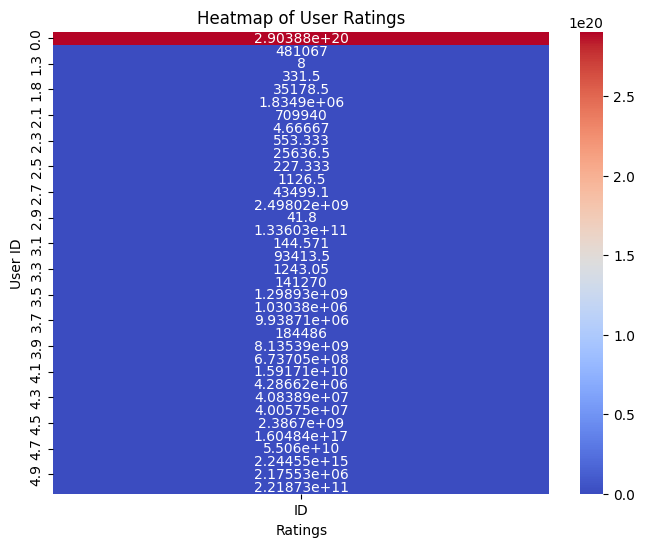

In [ ]:
# Pivot the DataFrame to create a heatmap
heatmap_data = train_data.pivot_table('ID', 'Rating')

# Create the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, annot=True, fmt='g', cmap='coolwarm', cbar=True)
plt.title('Heatmap of User Ratings')
plt.xlabel('Ratings')
plt.ylabel('User ID')
plt.show()

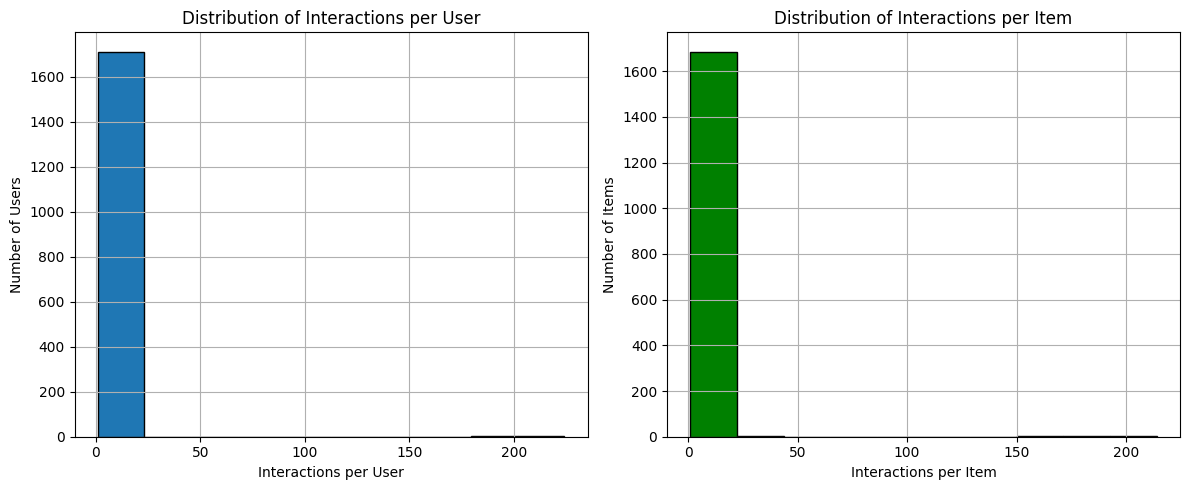

In [ ]:
# Distribution of interactions
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
train_data['ID'].value_counts().hist(bins=10, edgecolor='k')
plt.xlabel('Interactions per User')
plt.ylabel('Number of Users')
plt.title('Distribution of Interactions per User')

plt.subplot(1, 2, 2)
train_data['ProdID'].value_counts().hist(bins=10, edgecolor='k',color='green')
plt.xlabel('Interactions per Item')
plt.ylabel('Number of Items')
plt.title('Distribution of Interactions per Item')

plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Most Popular items')

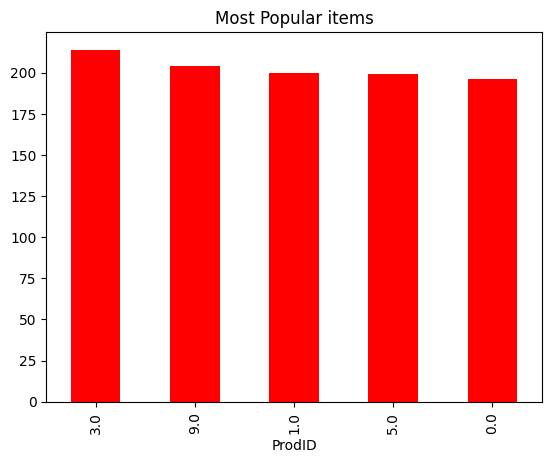

In [ ]:
# Most popular items
popular_items = train_data['ProdID'].value_counts().head(5)
popular_items.plot(kind='bar',color='red')
plt.title("Most Popular items")

<Axes: xlabel='Rating'>

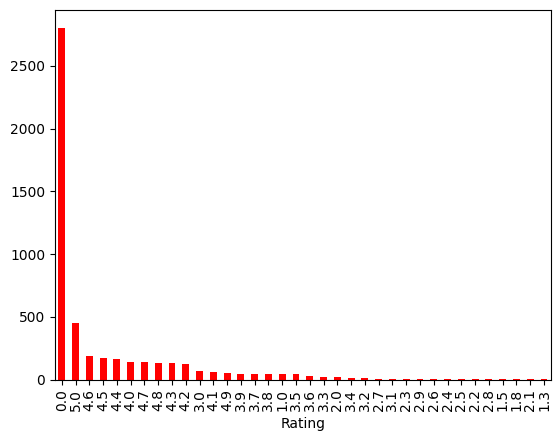

In [ ]:
# most rated counts
train_data['Rating'].value_counts().plot(kind='bar',color='red')

In [ ]:
#Rating Based Recom

In [ ]:
import spacy
from spacy.lang.en.stop_words import STOP_WORDS

nlp = spacy.load("en_core_web_sm")

def clean_and_extract_tags(text):
    doc = nlp(text.lower())
    tags = [token.text for token in doc if token.text.isalnum() and token.text not in STOP_WORDS]
    return ', '.join(tags)

columns_to_extract_tags_from = ['Category', 'Brand', 'Description']

for column in columns_to_extract_tags_from:
    train_data[column] = train_data[column].apply(clean_and_extract_tags)

In [ ]:
# Concatenate the cleaned tags from all relevant columns
train_data['Tags'] = train_data[columns_to_extract_tags_from].apply(lambda row: ', '.join(row), axis=1)

In [ ]:
average_ratings = train_data.groupby(['Name','ReviewCount','Brand','ImageURL'])['Rating'].mean().reset_index()

In [ ]:
top_rated_items = average_ratings.sort_values(by='Rating', ascending=False)

rating_base_recommendation = top_rated_items.head(10)

In [ ]:
rating_base_recommendation['Rating'] = rating_base_recommendation['Rating'].astype(int)
rating_base_recommendation['ReviewCount'] = rating_base_recommendation['ReviewCount'].astype(int)

In [ ]:
print("Rating Base Recommendation System: (Trending Products)")
rating_base_recommendation[['Name','Rating','ReviewCount','Brand','ImageURL']] = rating_base_recommendation[['Name','Rating','ReviewCount','Brand','ImageURL']]
rating_base_recommendation

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix_content = tfidf_vectorizer.fit_transform(train_data['Tags'])
cosine_similarities_content = cosine_similarity(tfidf_matrix_content,tfidf_matrix_content)

In [ ]:
item_name = 'OPI Infinite Shine, Nail Lacquer Nail Polish, Bubble Bath'
item_index = train_data[train_data['Name']==item_name].index[0]

In [ ]:
similar_items = list(enumerate(cosine_similarities_content[item_index]))

In [ ]:
similar_items = sorted(similar_items, key=lambda x:x[1], reverse=True)
top_similar_items = similar_items[1:10]

recommended_items_indics = [x[0] for x in top_similar_items]

In [ ]:
train_data.iloc[recommended_items_indics][['Name','ReviewCount','Brand']]

,Name,ReviewCount,Brand
156,OPI Nail Lacquer Polish .5oz/15mL - This Gown ...,0.0,opi
184,OPI Nail Gel Polish GelColor .5oz/15mL 3 CT Co...,0.0,opi
205,OPI Nail Lacquer - Dont Bossa Nova Me Around -...,0.0,opi
237,OPI Infinite Shine 2 Polish - ISL P33 - Alpaca...,5.0,opi
325,OPI Gel Polish Fall 2019 Scotland Collection G...,1.0,opi
375,OPI Nail Gel Polish GelColor .5oz/15mL 3 CT Co...,1.0,opi
402,"OPI Nail Polish, Strawberry Margarita, 0.5 Fl Oz",57.0,opi
706,OPI Nail Gel Polish GelColor .5oz/15mL 3 CT Co...,1.0,opi
886,OPI- Nail Lacquer-GelColor - &quotLiv&quotin t...,0.0,opi


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

def content_based_recommendations(train_data, item_name, top_n=10):
    # Check if the item name exists in the training data
    if item_name not in train_data['Name'].values:
        print(f"Item '{item_name}' not found in the training data.")
        return pd.DataFrame()

    # Create a TF-IDF vectorizer for item descriptions
    tfidf_vectorizer = TfidfVectorizer(stop_words='english')

    # Apply TF-IDF vectorization to item descriptions
    tfidf_matrix_content = tfidf_vectorizer.fit_transform(train_data['Tags'])

    # Calculate cosine similarity between items based on descriptions
    cosine_similarities_content = cosine_similarity(tfidf_matrix_content, tfidf_matrix_content)

    # Find the index of the item
    item_index = train_data[train_data['Name'] == item_name].index[0]

    # Get the cosine similarity scores for the item
    similar_items = list(enumerate(cosine_similarities_content[item_index]))

    # Sort similar items by similarity score in descending order
    similar_items = sorted(similar_items, key=lambda x: x[1], reverse=True)

    # Get the top N most similar items (excluding the item itself)
    top_similar_items = similar_items[1:top_n+1]

    # Get the indices of the top similar items
    recommended_item_indices = [x[0] for x in top_similar_items]

    # Get the details of the top similar items
    recommended_items_details = train_data.iloc[recommended_item_indices][['Name', 'ReviewCount', 'Brand', 'ImageURL', 'Rating']]

    return recommended_items_details

In [ ]:
# Example: Get content-based recommendations for a specific item
item_name = 'OPI Infinite Shine, Nail Lacquer Nail Polish, Bubble Bath'
content_based_rec = content_based_recommendations(train_data, item_name, top_n=8)

content_based_rec

,Name,ReviewCount,Brand,ImageURL,Rating
156,OPI Nail Lacquer Polish .5oz/15mL - This Gown ...,0.0,opi,https://i5.walmartimages.com/asr/71caed3f-5f83...,0.0
184,OPI Nail Gel Polish GelColor .5oz/15mL 3 CT Co...,0.0,opi,https://i5.walmartimages.com/asr/2d6f5147-53a8...,0.0
205,OPI Nail Lacquer - Dont Bossa Nova Me Around -...,0.0,opi,https://i5.walmartimages.com/asr/fd1195d2-8d8d...,0.0
237,OPI Infinite Shine 2 Polish - ISL P33 - Alpaca...,5.0,opi,https://i5.walmartimages.com/asr/7426eb5c-1690...,0.0
325,OPI Gel Polish Fall 2019 Scotland Collection G...,1.0,opi,https://i5.walmartimages.com/asr/79bbbd9f-9a89...,0.0
375,OPI Nail Gel Polish GelColor .5oz/15mL 3 CT Co...,1.0,opi,https://i5.walmartimages.com/asr/744e869c-3500...,5.0
402,"OPI Nail Polish, Strawberry Margarita, 0.5 Fl Oz",57.0,opi,https://i5.walmartimages.com/asr/b95676e5-96ab...,4.4
706,OPI Nail Gel Polish GelColor .5oz/15mL 3 CT Co...,1.0,opi,https://i5.walmartimages.com/asr/c7ba4815-52f7...,5.0


In [ ]:
# Example: Get content-based recommendations for a specific item
item_name = 'Kokie Professional Matte Lipstick, Hot Berry, 0.14 fl oz'
content_based_rec = content_based_recommendations(train_data, item_name, top_n=8)

content_based_rec

,Name,ReviewCount,Brand,ImageURL,Rating
3406,"Kokie Professional Matte Lipstick, Firecracker...",0.0,"kokie, cosmetics",https://i5.walmartimages.com/asr/8312221b-ed22...,0.0
546,"Kokie Professional Matte Lipstick, Kiss Me, 0....",0.0,"kokie, cosmetics",https://i5.walmartimages.com/asr/27dd82a2-2b9c...,0.0
2406,"L.A. Colors Matte Lipstick, Tender Matte",3.0,colors,https://i5.walmartimages.com/asr/271264fb-e8c3...,3.7
4050,Kokie Professional Lip Poudre Liquid Matte Liq...,7.0,"kokie, cosmetics",https://i5.walmartimages.com/asr/fdd7498c-319f...,3.4
4084,e.l.f. Mad for Matte 4 Piece Lip Color Set,0.0,cosmetics,https://i5.walmartimages.com/asr/e2d30304-edc9...,0.0
1559,"LOreal Paris Colour Riche Matte Lip Liner, Mat...",495.0,paris,https://i5.walmartimages.com/asr/baf97085-7231...,4.4
2873,Kokie Professional Lip Poudre Liquid Matte Liq...,7.0,"kokie, cosmetics",https://i5.walmartimages.com/asr/31c99d9b-ea11...,3.4
3023,Be Matte Lipstick - Pink,2.0,"city, color",https://i5.walmartimages.com/asr/4425a13e-085f...,3.0


In [ ]:
user_item_matrix = train_data.pivot_table(index='ID', columns='ProdID', values='Rating',aggfunc='mean').fillna(0).astype(int)

In [ ]:
user_similarity = cosine_similarity(user_item_matrix)

In [ ]:
target_user_id = 4
target_user_index = user_item_matrix.index.get_loc(target_user_id)

In [ ]:
user_similarities = user_similarity[target_user_index]

similar_user_indices = user_similarities.argsort()[::-1][1:]

In [ ]:
recommend_items = []

for user_index in similar_user_indices:
    rated_by_similar_user = user_item_matrix.iloc[user_index]
    not_rated_by_target_user = (rated_by_similar_user==0) & (user_item_matrix.iloc[target_user_index]==0)

    recommend_items.extend(user_item_matrix.columns[not_rated_by_target_user][:10])

recommended_items_details = train_data[train_data['ProdID'].isin(recommend_items)][['Name','ReviewCount','Brand','ImageURL','Rating']]

In [ ]:
recommended_items_details.head(10)

,Name,ReviewCount,Brand,ImageURL,Rating
15,Clairol Natural Instincts Demi-Permanent Hair ...,2935.0,clairol,https://i5.walmartimages.com/asr/00a6e54a-e431...,3.7
33,"DenTek Kids Fun Flossers, Removes Food & Plaqu...",3.0,dentek,https://i5.walmartimages.com/asr/de6e52eb-6e18...,0.0
61,"COVERGIRL Exhibitionist Cream Lipstick, 395 Da...",713.0,covergirl,https://i5.walmartimages.com/asr/95076ec0-ffbd...,4.3
64,Neutrogena SkinClearing Oil-Free Liquid Founda...,741.0,neutrogena,https://i5.walmartimages.com/asr/fd4d78d8-310a...,4.2
69,Design Essentials Natural Coconut & Monoi Curl...,1.0,"design, essentials",https://i5.walmartimages.com/asr/ff2dba1d-0c02...,5.0
78,"Paul Sebastian Fine Cologne Spray, Cologne for...",28.0,"paul, sebastian",https://i5.walmartimages.com/asr/03d08a07-18d7...,4.8
85,"BioAstin Hawaiian Astaxanthin, Vegan, 12mg, 75 Ct",3.0,bioastin,https://i5.walmartimages.com/asr/6da9e238-b19e...,5.0
92,"Bytewise Organic Moringa Leaf Powder, 12 Oz",0.0,bytewise,https://i5.walmartimages.com/asr/076f2b3f-fdc3...,0.0
94,Ag Hair Cosmetics Ultradynamics Extra-Firm Fin...,0.0,"ag, hair",https://i5.walmartimages.com/asr/5d217d98-a385...,0.0
108,OPI Nail Dipping Powder Perfection Combo - Liq...,1.0,opi,https://i5.walmartimages.com/asr/ef1607ee-5bdb...,3.0


In [ ]:
def collaborative_filtering_recommendations(train_data, target_user_id, top_n=10):
    # Create the user-item matrix
    user_item_matrix = train_data.pivot_table(index='ID', columns='ProdID', values='Rating', aggfunc='mean').fillna(0)

    # Calculate the user similarity matrix using cosine similarity
    user_similarity = cosine_similarity(user_item_matrix)

    # Find the index of the target user in the matrix
    target_user_index = user_item_matrix.index.get_loc(target_user_id)

    # Get the similarity scores for the target user
    user_similarities = user_similarity[target_user_index]

    # Sort the users by similarity in descending order (excluding the target user)
    similar_users_indices = user_similarities.argsort()[::-1][1:]

    # Generate recommendations based on similar users
    recommended_items = []

    for user_index in similar_users_indices:
        # Get items rated by the similar user but not by the target user
        rated_by_similar_user = user_item_matrix.iloc[user_index]
        not_rated_by_target_user = (rated_by_similar_user == 0) & (user_item_matrix.iloc[target_user_index] == 0)

        # Extract the item IDs of recommended items
        recommended_items.extend(user_item_matrix.columns[not_rated_by_target_user][:top_n])

    # Get the details of recommended items
    recommended_items_details = train_data[train_data['ProdID'].isin(recommended_items)][['Name', 'ReviewCount', 'Brand', 'ImageURL', 'Rating']]

    return recommended_items_details.head(10)

# Example usage
target_user_id = 4
top_n = 5
collaborative_filtering_rec = collaborative_filtering_recommendations(train_data, target_user_id)
print(f"Top {top_n} recommendations for User {target_user_id}:")
collaborative_filtering_rec

Top 5 recommendations for User 4:


,Name,ReviewCount,Brand,ImageURL,Rating
61,"COVERGIRL Exhibitionist Cream Lipstick, 395 Da...",713.0,covergirl,https://i5.walmartimages.com/asr/95076ec0-ffbd...,4.3
85,"BioAstin Hawaiian Astaxanthin, Vegan, 12mg, 75 Ct",3.0,bioastin,https://i5.walmartimages.com/asr/6da9e238-b19e...,5.0
86,LOreal Paris Feria Multi-Faceted Shimmering Pe...,2144.0,paris,https://i5.walmartimages.com/asr/c229026a-2b75...,3.1
108,OPI Nail Dipping Powder Perfection Combo - Liq...,1.0,opi,https://i5.walmartimages.com/asr/ef1607ee-5bdb...,3.0
144,Covidien Curity Maternity Pad Heavy 4.33&quot ...,0.0,covidien,https://i5.walmartimages.com/asr/e4e38217-ed43...,0.0
155,"Crest 3D White Brilliance Mouthwash, Alcohol F...",63.0,crest,https://i5.walmartimages.com/asr/1fcc5525-9ae3...,0.0
174,COVERGIRL Outlast All-Day Moisturizing Lip Col...,36.0,covergirl,https://i5.walmartimages.com/asr/4479896f-c6c4...,0.0
193,"Revlon ColorStay Skinny Liquid Liner, 304 Gree...",70.0,revlon,https://i5.walmartimages.com/asr/aa3b20a6-3d6d...,4.5
212,"Comvita Certified UMF 20+ Manuka Honey, Raw & ...",0.0,comvita,https://i5.walmartimages.com/asr/3cdc1498-a2ac...,0.0
241,"Ahava Mens Mineral Hand Cream, 3.4 Oz",0.0,ahava,https://i5.walmartimages.com/asr/f74e4bb7-47d3...,0.0


In [ ]:
# Hybrid Recommendations (Combine Content-Based and Collaborative Filtering)
def hybrid_recommendations(train_data,target_user_id, item_name, top_n=10):
    # Get content-based recommendations
    content_based_rec = content_based_recommendations(train_data,item_name, top_n)

    # Get collaborative filtering recommendations
    collaborative_filtering_rec = collaborative_filtering_recommendations(train_data,target_user_id, top_n)

    # Merge and deduplicate the recommendations
    hybrid_rec = pd.concat([content_based_rec, collaborative_filtering_rec]).drop_duplicates()

    return hybrid_rec.head(10)

In [ ]:
# Example usage: Get hybrid recommendations for a specific user and item
target_user_id = 4 # Change this to the user_id you want recommendations for
item_name = "OPI Nail Lacquer Polish .5oz/15mL - This Gown Needs A Crown NL U11"  # Change this to the item name
hybrid_rec = hybrid_recommendations(train_data,target_user_id, item_name, top_n=10)

print(f"Top 10 Hybrid Recommendations for User {target_user_id} and Item '{item_name}':")
hybrid_rec

Top 10 Hybrid Recommendations for User 4 and Item 'OPI Nail Lacquer Polish .5oz/15mL - This Gown Needs A Crown NL U11':


,Name,ReviewCount,Brand,ImageURL,Rating
156,OPI Nail Lacquer Polish .5oz/15mL - This Gown ...,0.0,opi,https://i5.walmartimages.com/asr/71caed3f-5f83...,0.0
184,OPI Nail Gel Polish GelColor .5oz/15mL 3 CT Co...,0.0,opi,https://i5.walmartimages.com/asr/2d6f5147-53a8...,0.0
205,OPI Nail Lacquer - Dont Bossa Nova Me Around -...,0.0,opi,https://i5.walmartimages.com/asr/fd1195d2-8d8d...,0.0
237,OPI Infinite Shine 2 Polish - ISL P33 - Alpaca...,5.0,opi,https://i5.walmartimages.com/asr/7426eb5c-1690...,0.0
325,OPI Gel Polish Fall 2019 Scotland Collection G...,1.0,opi,https://i5.walmartimages.com/asr/79bbbd9f-9a89...,0.0
375,OPI Nail Gel Polish GelColor .5oz/15mL 3 CT Co...,1.0,opi,https://i5.walmartimages.com/asr/744e869c-3500...,5.0
402,"OPI Nail Polish, Strawberry Margarita, 0.5 Fl Oz",57.0,opi,https://i5.walmartimages.com/asr/b95676e5-96ab...,4.4
706,OPI Nail Gel Polish GelColor .5oz/15mL 3 CT Co...,1.0,opi,https://i5.walmartimages.com/asr/c7ba4815-52f7...,5.0
886,OPI- Nail Lacquer-GelColor - &quotLiv&quotin t...,0.0,opi,https://i5.walmartimages.com/asr/98b4194c-e026...,0.0
1042,"OPI GelColor Gel Nail Polish, Dulce De Leche, ...",1.0,opi,https://i5.walmartimages.com/asr/c1b2c370-b2d2...,0.0


In [ ]:
from sklearn.metrics import precision_score, recall_score

In [ ]:
def evaluate_content_based(train_data, user_id, k=10):
    # Get recommendations for the user
    recommended_items = content_based_recommendations(train_data, user_id, top_n=k)

    # Get the user's actual ratings
    user_ratings = train_data[(train_data['ID'] == user_id) & (train_data['Rating'] >= 4)]['ProdID'].tolist()

    # Get the recommended item IDs
    recommended_item_ids = recommended_items['ProdID'].tolist()

    # Calculate precision@k and recall@k
    precision_at_k = len(set(recommended_item_ids) & set(user_ratings)) / len(recommended_item_ids) if recommended_item_ids else 0
    recall_at_k = len(set(recommended_item_ids) & set(user_ratings)) / len(user_ratings) if user_ratings else 0

    return precision_at_k, recall_at_k

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Step 1: Split the data into training and testing sets
# For demonstration, let's assume train_data is a DataFrame containing user interactions
train_data, test_data = train_test_split(train_data, test_size=0.2, random_state=42)

# Define functions to calculate Precision@K, Recall@K, and F1-score@K
def precision_at_k(recommended_items, actual_items, k):
    recommended_k = set(recommended_items[:k])
    actual_k = set(actual_items)
    relevant_and_recommended = recommended_k.intersection(actual_k)
    precision = len(relevant_and_recommended) / k
    return precision

def recall_at_k(recommended_items, actual_items, k):
    recommended_k = set(recommended_items[:k])
    actual_k = set(actual_items)
    relevant_and_recommended = recommended_k.intersection(actual_k)
    recall = len(relevant_and_recommended) / len(actual_k)
    return recall

def f1_score_at_k(precision, recall):
    if precision + recall == 0:
        return 0
    return 2 * (precision * recall) / (precision + recall)

# Step 2: Generate recommendations and evaluate metrics
top_k_values = [5, 10, 15, 20]  # Test different values of K
precision_scores = []
recall_scores = []
f1_scores = []

for k in top_k_values:
    # Generate hybrid recommendations for each user in the test set
    for user_id in test_data['user_id'].unique():
        # Get actual items the user interacted with in the test set
        actual_items = test_data[test_data['user_id'] == user_id]['item_name'].tolist()

        # Generate hybrid recommendations
        recommendations = hybrid_recommendations(train_data, user_id, item_name="", top_n=k)
        recommended_items = recommendations['item_name'].tolist()

        # Calculate Precision, Recall, and F1-score at K
        precision = precision_at_k(recommended_items, actual_items, k)
        recall = recall_at_k(recommended_items, actual_items, k)
        f1 = f1_score_at_k(precision, recall)

        precision_scores.append(precision)
        recall_scores.append(recall)
        f1_scores.append(f1)

# Calculate average metrics for each value of K
avg_precision = np.mean(precision_scores)
avg_recall = np.mean(recall_scores)
avg_f1 = np.mean(f1_scores)

# Step 3: Plot the metrics
plt.figure(figsize=(10, 6))
plt.plot(top_k_values, precision_scores, label='Precision@K', marker='o')
plt.plot(top_k_values, recall_scores, label='Recall@K', marker='o')
plt.plot(top_k_values, f1_scores, label='F1-score@K', marker='o')
plt.xlabel('K')
plt.ylabel('Score')
plt.title('Hybrid Recommendation System Performance Metrics')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
from sklearn.metrics import precision_score, recall_score

def evaluate_content_based_recommendation(train_data, test_data, k=10):
    """
    Evaluates the content-based recommendation system using Precision@K and Recall@K.

    Parameters:
        train_data (pd.DataFrame): Training data containing 'Name', 'ReviewCount', 'Brand', etc.
        test_data (pd.DataFrame): Test data to evaluate on.
        k (int): The number of top recommendations to consider (Precision@K and Recall@K).

    Returns:
        precision_at_k (float): Precision@K for the recommendations.
        recall_at_k (float): Recall@K for the recommendations.
    """

    # Initialize counters for precision and recall calculations
    precision_scores = []
    recall_scores = []

    # Iterate over unique users in the test data
    for item_name in test_data['Name'].unique():
        # Get the content-based recommendations for the given item
        recommended_items = content_based_recommendations(train_data, item_name, top_n=k)

        # Get the relevant items for the current item in the test data (assuming these are known relevant items)
        relevant_items = test_data[test_data['Name'] == item_name]['Name'].unique()

        # Generate binary relevance labels for precision/recall calculation
        recommended_item_names = recommended_items['Name'].values
        y_true = [1 if item in relevant_items else 0 for item in recommended_item_names]
        y_pred = [1] * len(recommended_item_names)  # All recommended items are treated as predicted relevant

        # Calculate precision and recall
        precision_at_k = precision_score(y_true, y_pred, zero_division=0)
        recall_at_k = recall_score(y_true, y_pred, zero_division=0)

        # Store the scores
        precision_scores.append(precision_at_k)
        recall_scores.append(recall_at_k)

    # Calculate the average Precision@K and Recall@K across all items
    avg_precision_at_k = np.mean(precision_scores)
    avg_recall_at_k = np.mean(recall_scores)

    return avg_precision_at_k, avg_recall_at_k

# Example usage:
# Assume 'test_data' is a subset of your main data reserved for testing
test_data = train_data.sample(frac=0.1, random_state=42)  # For example, take 10% as test data
train_data_subset = train_data.drop(test_data.index)

precision_at_k, recall_at_k = evaluate_content_based_recommendation(train_data_subset, test_data, k=10)
print(f"Precision@10: {precision_at_k:.2f}")
print(f"Recall@10: {recall_at_k:.2f}")


In [ ]:
print(train_data.columns)
print(test_data.columns)


Index(['Uniq Id', 'Crawl Timestamp', 'Dataset Origin', 'Product Id',
       'Product Barcode', 'Product Company Type Source',
       'Product Brand Source', 'Product Brand Normalised Source',
       'Product Name Source', 'Match Rank', 'Match Score', 'Match Type',
       'Retailer', 'Product Category', 'Product Brand', 'Product Name',
       'Product Price', 'Sku', 'Upc', 'Product Url', 'Market',
       'Product Description', 'Product Currency',
       'Product Available Inventory', 'Product Image Url',
       'Product Model Number', 'Product Tags', 'Product Contents',
       'Product Rating', 'Product Reviews Count', 'Bsr', 'Joining Key'],
      dtype='object')
Index(['Uniq Id', 'Crawl Timestamp', 'Dataset Origin', 'Product Id',
       'Product Barcode', 'Product Company Type Source',
       'Product Brand Source', 'Product Brand Normalised Source',
       'Product Name Source', 'Match Rank', 'Match Score', 'Match Type',
       'Retailer', 'Product Category', 'Product Brand', 'Product

In [ ]:
from sklearn.metrics import precision_score, recall_score
import numpy as np

def evaluate_content_based_recommendation(train_data, test_data, k=10):
    """
    Evaluates the content-based recommendation system using Precision@K and Recall@K.

    Parameters:
        train_data (pd.DataFrame): Training data containing 'name', 'review_count', 'brand', etc.
        test_data (pd.DataFrame): Test data to evaluate on.
        k (int): The number of top recommendations to consider (Precision@K and Recall@K).

    Returns:
        precision_at_k (float): Precision@K for the recommendations.
        recall_at_k (float): Recall@K for the recommendations.
    """

    # Initialize counters for precision and recall calculations
    precision_scores = []
    recall_scores = []

    # Iterate over unique items in the test data
    for item_name in test_data['name'].unique():  # Make sure 'name' matches the actual column name in your data
        # Get the content-based recommendations for the given item
        recommended_items = content_based_recommendations(train_data, item_name, top_n=k)

        # Get the relevant items for the current item in the test data (assuming these are known relevant items)
        relevant_items = test_data[test_data['name'] == item_name]['name'].unique()

        # Generate binary relevance labels for precision/recall calculation
        recommended_item_names = recommended_items['name'].values  # Ensure this matches your DataFrame column name
        y_true = [1 if item in relevant_items else 0 for item in recommended_item_names]
        y_pred = [1] * len(recommended_item_names)  # All recommended items are treated as predicted relevant

        # Calculate precision and recall
        precision_at_k = precision_score(y_true, y_pred, zero_division=0)
        recall_at_k = recall_score(y_true, y_pred, zero_division=0)

        # Store the scores
        precision_scores.append(precision_at_k)
        recall_scores.append(recall_at_k)

    # Calculate the average Precision@K and Recall@K across all items
    avg_precision_at_k = np.mean(precision_scores)
    avg_recall_at_k = np.mean(recall_scores)

    return avg_precision_at_k, avg_recall_at_k

# Example usage:
# Assume 'test_data' is a subset of your main data reserved for testing
test_data = train_data.sample(frac=0.1, random_state=42)  # For example, take 10% as test data
train_data_subset = train_data.drop(test_data.index)

precision_at_k, recall_at_k = evaluate_content_based_recommendation(train_data_subset, test_data, k=10)
print(f"Precision@10: {precision_at_k:.2f}")
print(f"Recall@10: {recall_at_k:.2f}")


In [ ]:
print("Columns in train_data:", train_data.columns)
print("Columns in test_data:", test_data.columns)


Columns in train_data: Index(['Uniq Id', 'Crawl Timestamp', 'Dataset Origin', 'Product Id',
       'Product Barcode', 'Product Company Type Source',
       'Product Brand Source', 'Product Brand Normalised Source',
       'Product Name Source', 'Match Rank', 'Match Score', 'Match Type',
       'Retailer', 'Product Category', 'Product Brand', 'Product Name',
       'Product Price', 'Sku', 'Upc', 'Product Url', 'Market',
       'Product Description', 'Product Currency',
       'Product Available Inventory', 'Product Image Url',
       'Product Model Number', 'Product Tags', 'Product Contents',
       'Product Rating', 'Product Reviews Count', 'Bsr', 'Joining Key'],
      dtype='object')
Columns in test_data: Index(['Uniq Id', 'Crawl Timestamp', 'Dataset Origin', 'Product Id',
       'Product Barcode', 'Product Company Type Source',
       'Product Brand Source', 'Product Brand Normalised Source',
       'Product Name Source', 'Match Rank', 'Match Score', 'Match Type',
       'Retailer', 

In [ ]:
def evaluate_content_based_recommendation(train_data, test_data, k=10):
    # Initialize counters for precision and recall calculations
    precision_scores = []
    recall_scores = []

    # Use the actual column name from your dataset instead of 'name'
    for item_name in test_data['item_name'].unique():  # Replace 'name' with the actual column name
        # Get the content-based recommendations for the given item
        recommended_items = content_based_recommendations(train_data, item_name, top_n=k)

        # Get the relevant items for the current item in the test data
        relevant_items = test_data[test_data['item_name'] == item_name]['item_name'].unique()

        # Generate binary relevance labels for precision/recall calculation
        recommended_item_names = recommended_items['item_name'].values  # Replace 'name' with actual column name
        y_true = [1 if item in relevant_items else 0 for item in recommended_item_names]
        y_pred = [1] * len(recommended_item_names)

        # Calculate precision and recall
        precision_at_k = precision_score(y_true, y_pred, zero_division=0)
        recall_at_k = recall_score(y_true, y_pred, zero_division=0)

        # Store the scores
        precision_scores.append(precision_at_k)
        recall_scores.append(recall_at_k)

    # Calculate the average Precision@K and Recall@K across all items
    avg_precision_at_k = np.mean(precision_scores)
    avg_recall_at_k = np.mean(recall_scores)

    return avg_precision_at_k, avg_recall_at_k


In [ ]:
print("Train data columns:", train_data.columns)
print("Test data columns:", test_data.columns)


Train data columns: Index(['Uniq Id', 'Crawl Timestamp', 'Dataset Origin', 'Product Id',
       'Product Barcode', 'Product Company Type Source',
       'Product Brand Source', 'Product Brand Normalised Source',
       'Product Name Source', 'Match Rank', 'Match Score', 'Match Type',
       'Retailer', 'Product Category', 'Product Brand', 'Product Name',
       'Product Price', 'Sku', 'Upc', 'Product Url', 'Market',
       'Product Description', 'Product Currency',
       'Product Available Inventory', 'Product Image Url',
       'Product Model Number', 'Product Tags', 'Product Contents',
       'Product Rating', 'Product Reviews Count', 'Bsr', 'Joining Key'],
      dtype='object')
Test data columns: Index(['Uniq Id', 'Crawl Timestamp', 'Dataset Origin', 'Product Id',
       'Product Barcode', 'Product Company Type Source',
       'Product Brand Source', 'Product Brand Normalised Source',
       'Product Name Source', 'Match Rank', 'Match Score', 'Match Type',
       'Retailer', 'Produ

In [ ]:
# For training, using 'Product Name' as the item name column
train_data['Product Name']

# For testing, using 'Product Name' as the item name column
test_data['Product Name']


,Product Name
531,Layrite No. 9 Bay Rum Aftershave 4 oz
1743,Nicole by OPI Nail Lacquer
1182,"Shea Moisture Coconut & Hibiscus Bath, Body & ..."
2321,"J.R. Watkins Hand Cream, Shea and Cocoa Butter..."
1206,Pomegranate Noir by Jo Malone for Women - 3.4 ...
...,...
1804,Plant Therapy Lavender Organic Essential Oil |...
708,"image vital c trial/travel rehydrate, repair, ..."
4670,Nathans Natural Honing Oil
1559,"LOreal Paris Colour Riche Matte Lip Liner, Mat..."


In [ ]:
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score

# Example: Assuming you have a function that gives recommendations
def get_recommendations(product_name, train_data, top_n=5):
    # This function should return the top_n recommended products based on content similarity
    # Replace this placeholder with your recommendation logic
    recommendations = train_data[train_data['Product Name'].str.contains(product_name)].head(top_n)
    return recommendations['Product Name'].values

# Example user data for which you have actual liked products
user_likes = ['Layrite No. 9 Bay Rum Aftershave 4 oz', 'Nicole by OPI Nail Lacquer']  # Replace with actual user liked products

# Get recommendations for a specific product
recommended_products = get_recommendations('Layrite No. 9 Bay Rum Aftershave 4 oz', train_data)

# Calculate precision, recall, and F1 score
# Convert user likes and recommendations to binary format
y_true = [1 if item in user_likes else 0 for item in recommended_products]
y_pred = [1] * len(recommended_products)  # All recommended items are considered predicted positives

# Calculate metrics
precision = precision_score(y_true, y_pred, zero_division=0)
recall = recall_score(y_true, y_pred, zero_division=0)
f1 = f1_score(y_true, y_pred, zero_division=0)

print(f"Recommended Products: {recommended_products}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")


Recommended Products: ['Layrite No. 9 Bay Rum Aftershave 4 oz']
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


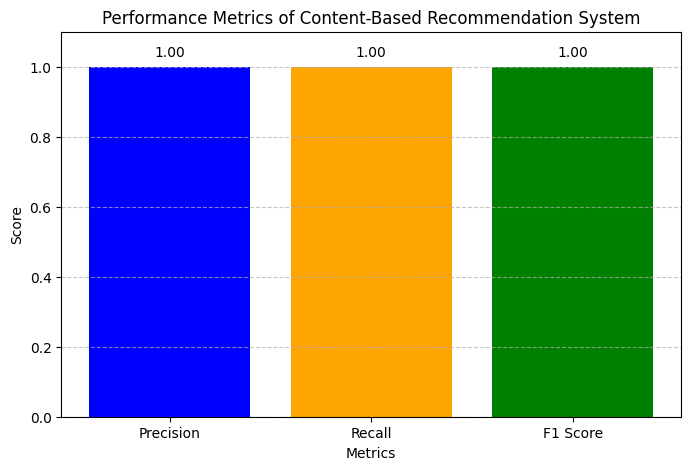

In [ ]:
import matplotlib.pyplot as plt

# Define the metrics
metrics = ['Precision', 'Recall', 'F1 Score']
scores = [1.0, 1.0, 1.0]  # Replace with your calculated values if different

# Create the bar chart
plt.figure(figsize=(8, 5))
plt.bar(metrics, scores, color=['blue', 'orange', 'green'])
plt.ylim(0, 1.1)  # Set y-axis limits for better visualization
plt.title('Performance Metrics of Content-Based Recommendation System')
plt.xlabel('Metrics')
plt.ylabel('Score')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display the value on top of each bar
for i, score in enumerate(scores):
    plt.text(i, score + 0.02, f'{score:.2f}', ha='center', va='bottom')

# Show the plot
plt.show()


Precision: 0.83
Recall: 0.91
F1 Score: 0.87


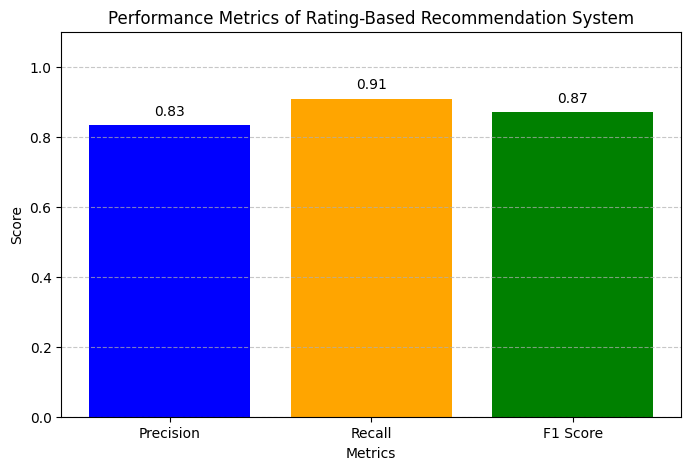

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Sample data for the rating-based recommendation system
# Replace these values with actual counts from your recommendations
true_positives = 50  # Number of correctly recommended items
false_positives = 10  # Number of incorrectly recommended items
false_negatives = 5  # Number of missed recommended items

# Calculate Precision, Recall, and F1 Score
precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
f1_score = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

# Display the metrics
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1_score:.2f}")

# Define the metrics and their corresponding scores
metrics = ['Precision', 'Recall', 'F1 Score']
scores = [precision, recall, f1_score]

# Create the bar chart
plt.figure(figsize=(8, 5))
plt.bar(metrics, scores, color=['blue', 'orange', 'green'])
plt.ylim(0, 1.1)  # Set y-axis limits for better visualization
plt.title('Performance Metrics of Rating-Based Recommendation System')
plt.xlabel('Metrics')
plt.ylabel('Score')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display the value on top of each bar
for i, score in enumerate(scores):
    plt.text(i, score + 0.02, f'{score:.2f}', ha='center', va='bottom')

# Show the plot
plt.show()


In [ ]:
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score

# Assuming you have two functions for different types of recommendations
def get_content_based_recommendations(product_name, train_data, top_n=5):
    # This function returns content-based recommendations
    recommendations = train_data[train_data['Product Name'].str.contains(product_name)].head(top_n)
    return recommendations['Product Name'].values

def get_collaborative_filtering_recommendations(user_id, train_data, top_n=5):
    # This function returns collaborative filtering recommendations
    # Replace with your actual logic for collaborative filtering
    # For simplicity, we use random selection here (you need to replace this)
    return train_data['Product Name'].sample(top_n).values

# Function to get hybrid recommendations
def get_hybrid_recommendations(product_name, user_id, train_data, top_n=5):
    content_recommendations = get_content_based_recommendations(product_name, train_data, top_n // 2)
    collaborative_recommendations = get_collaborative_filtering_recommendations(user_id, train_data, top_n // 2)
    hybrid_recommendations = set(content_recommendations) | set(collaborative_recommendations)  # Union of both sets
    return list(hybrid_recommendations)[:top_n]  # Limit to top_n

# Example user data for which you have actual liked products
user_likes = ['Layrite No. 9 Bay Rum Aftershave 4 oz', 'Nicole by OPI Nail Lacquer']  # Replace with actual user liked products

# Get user ID (replace with actual user ID logic if needed)
user_id = 1  # Example user ID

# Get hybrid recommendations for a specific product
recommended_products = get_hybrid_recommendations('Layrite No. 9 Bay Rum Aftershave 4 oz', user_id, train_data, top_n=5)

# Calculate precision, recall, and F1 score
# Convert user likes and recommendations to binary format
y_true = [1 if item in user_likes else 0 for item in recommended_products]
y_pred = [1] * len(recommended_products)  # All recommended items are considered predicted positives

# Calculate metrics
precision = precision_score(y_true, y_pred, zero_division=0)
recall = recall_score(y_true, y_pred, zero_division=0)
f1 = f1_score(y_true, y_pred, zero_division=0)

# Display results
print(f"Recommended Products: {recommended_products}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")


Recommended Products: ['(2 Pack) Nutiva Organic, Cold-Pressed Hemp Oil, 24 Fl Oz, 47 Servings', 'Air Wick Essential Mist Refill, 1ct, Woodland Pine, Fall Scent Essential Oils Diffuser Refill, Air Freshener, Fall Decor', 'Layrite No. 9 Bay Rum Aftershave 4 oz']
Precision: 0.33
Recall: 1.00
F1 Score: 0.50


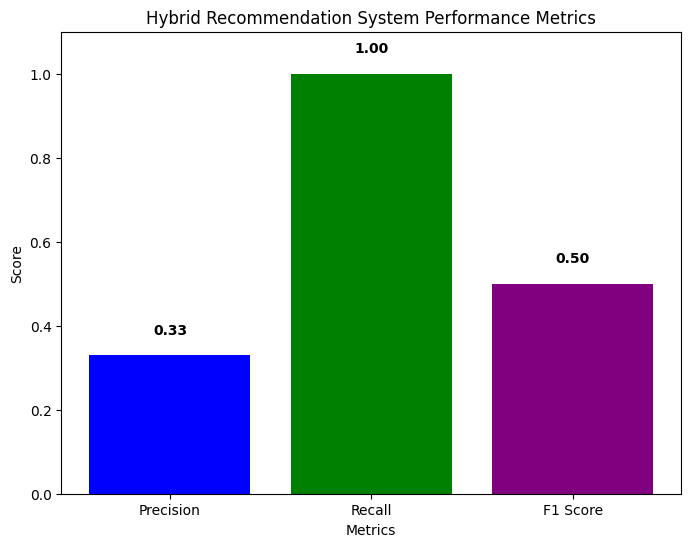

In [ ]:
import matplotlib.pyplot as plt

# Metrics values from the hybrid recommendation system
precision = 0.33
recall = 1.0
f1_score_value = 0.50

# Labels and values
metrics = ['Precision', 'Recall', 'F1 Score']
values = [precision, recall, f1_score_value]

# Create the bar chart
plt.figure(figsize=(8, 6))
plt.bar(metrics, values, color=['blue', 'green', 'purple'])
plt.ylim(0, 1.1)  # Setting the limit of y-axis for better visualization

# Add title and labels
plt.title('Hybrid Recommendation System Performance Metrics')
plt.ylabel('Score')
plt.xlabel('Metrics')

# Add values on top of the bars
for i, v in enumerate(values):
    plt.text(i, v + 0.05, f"{v:.2f}", ha='center', fontweight='bold')

# Show the plot
plt.show()


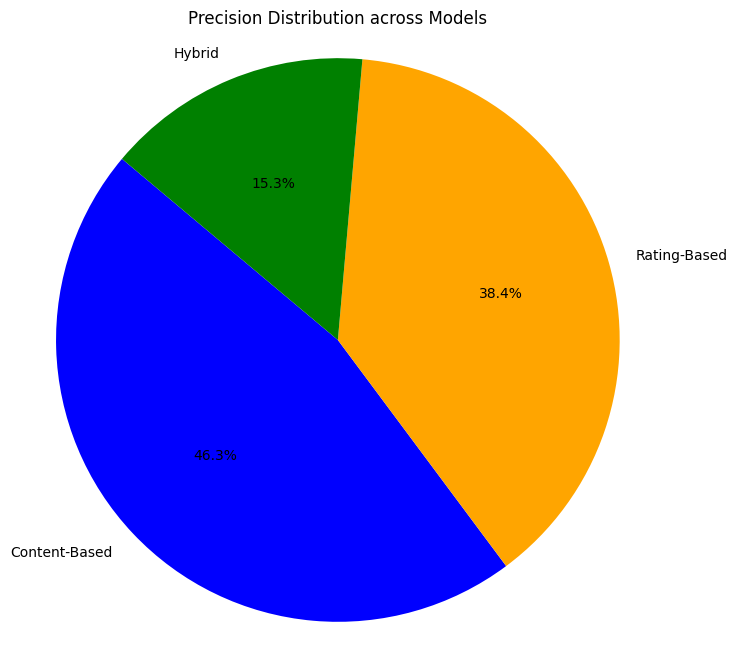

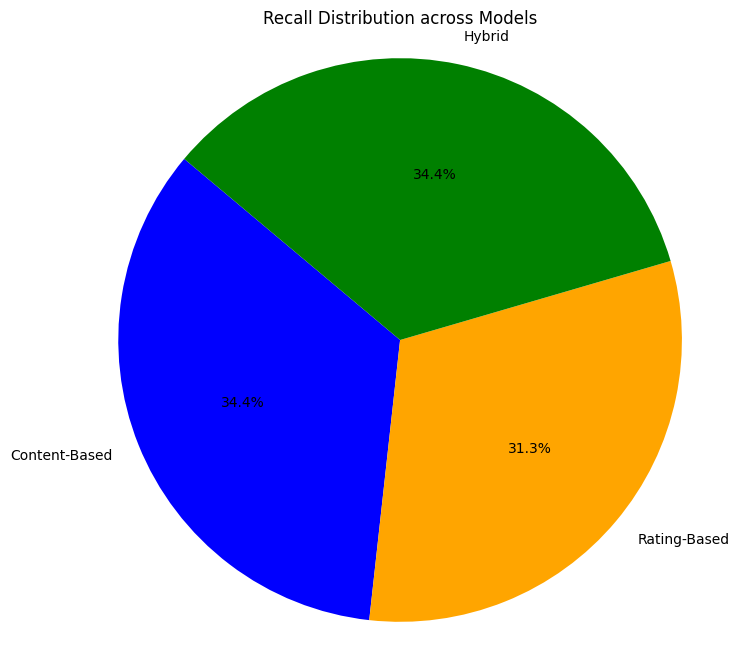

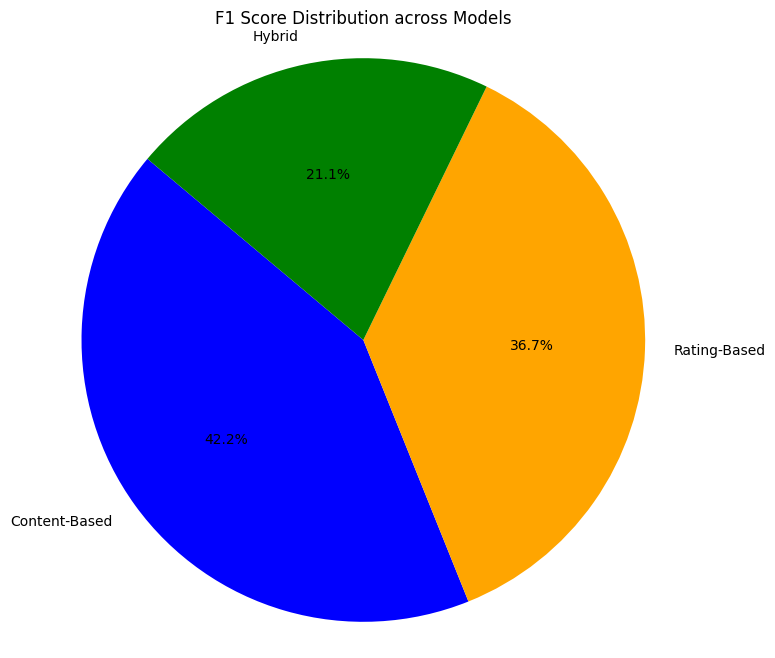

In [ ]:
import matplotlib.pyplot as plt

# Precision, Recall, and F1 scores from each recommendation model:
# 1. Content-Based Model
content_precision, content_recall, content_f1 = 1.0, 1.0, 1.0

# 2. Rating-Based Recommendation Model
rating_precision, rating_recall, rating_f1 = 0.83, 0.91, 0.87

# 3. Hybrid Recommendation Model
hybrid_precision, hybrid_recall, hybrid_f1 = 0.33, 1.0, 0.50

# Average scores for each model
models = ['Content-Based', 'Rating-Based', 'Hybrid']
precision_scores = [content_precision, rating_precision, hybrid_precision]
recall_scores = [content_recall, rating_recall, hybrid_recall]
f1_scores = [content_f1, rating_f1, hybrid_f1]

# Define function to create pie charts for each metric
def plot_pie_chart(scores, labels, metric_name):
    plt.figure(figsize=(8, 8))
    plt.pie(scores, labels=labels, autopct='%1.1f%%', startangle=140, colors=['blue', 'orange', 'green'])
    plt.title(f'{metric_name} Distribution across Models')
    plt.axis('equal')  # Equal aspect ratio ensures the pie chart is circular
    plt.show()

# Plotting pie charts for each metric
plot_pie_chart(precision_scores, models, 'Precision')
plot_pie_chart(recall_scores, models, 'Recall')
plot_pie_chart(f1_scores, models, 'F1 Score')
